In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

## **Load and processing database**

In [2]:
df = pd.read_excel('../data/experimental_data/data.xlsx')
df.drop(df.columns[0], axis = 1, inplace = True)
df.drop(labels = [16],axis = 0, inplace = True) # delete a line with another catalyst
df.drop(df.columns[2], axis = 1, inplace = True) # delete the catalyst column
df.drop(labels = [19,20,28],axis = 0, inplace = True) # delete lines with hydrochloride and insoluble bases
df.drop(columns = ['Amount of electrolyte (M)'], axis = 1, inplace = True) # delete the column with the amount of electrolyte
df

,Reagent 1,Reagent 2,Ligand,Amount of ligand (mol %),Base,Amount of base (eq.),Solvent,Electrolyte,Frequency (Hz),Temperature(C),Time (h),NMR yield (%),Current type
0,Bromobenzene,Morpholine,di-tBuBipy,15.0,-,0.0,DMA,LiBr,5.0,20,2,80,AC
1,Bromobenzene,Morpholine,Bipy,15.0,-,0.0,DMA,LiBr,5.0,20,2,79,AC
2,Bromobenzene,Morpholine,BPhen,15.0,-,0.0,DMA,LiBr,5.0,20,2,44,AC
3,Bromobenzene,Morpholine,di-tBuBipy,10.0,-,0.0,DMA,LiBr,5.0,20,2,78,AC
4,Bromobenzene,Morpholine,di-tBuBipy,20.0,-,0.0,DMA,LiBr,5.0,20,2,77,AC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,4-F3C-PhBr,n-hexanol,Bipy,10.0,Quinuclidine,2.0,DMF,LiBr,2.0,20,8,26,DC
97,3-bromopyridine,1-hexanol,Bipy,10.0,Quinuclidine,2.0,DMF,LiBr,10.0,20,8,29,DC
98,4-F3C-PhBr,Boc-L-proline,Bipy,10.0,K2CO3,10.0,DMA,TBAPF6,2.0,60,4,13,DC
99,4-bromobenzonitrile,Boc-L-proline,Bipy,10.0,K2CO3,10.0,DMA,TBAPF6,2.0,60,4,23,DC



### **Load calculated data and adding it to the dataset**

In [3]:
dft_r1 = pd.read_excel('../data/calculated_data/DFT_R1.xlsx')
dft_r1

,Reagent 1,HOMO_R1,LUMO_R1,MU_R1
0,"2,6-MeO2-PhBr",-0.496,-6.145,3.04663
1,2-bromotoluene,-6.711,-0.720,1.60165
2,2-NpBr,-7.330,-0.351,2.86425
3,3-bromopyridine,-7.179,-1.412,2.05234
4,3-Cl-PhBr,-7.179,-1.412,1.69037
5,3-MeO-PhBr,-6.449,-0.759,3.24055
6,4-Ac-PhBr,-7.124,-2.126,2.48449
7,4-bromobenzonitrile,-7.347,-2.067,3.16853
8,4-Br-Ph-COOH,-7.196,-2.017,1.44692
9,4-F3C-PhBr,-7.332,-1.560,1.37144


In [4]:
dft_r2 = pd.read_excel('../data/calculated_data/DFT_R2.xlsx')
dft_r2

,Reagent 2,HOMO_R2,LUMO_R2,MU_R2
0,1-hexanol,-7.492,0.380,1.83414
1,1-hexylamine,-6.414,0.513,1.29670
2,2-propanol,-7.561,0.322,1.70416
3,4-TolNH2,-5.459,-0.233,1.36911
4,benzoic_acid,-7.385,-1.745,2.19298
5,benzyl_alcohol,-6.899,-0.649,1.59255
6,Boc-L-glutamic_acid_5-tert-butyl_ester,-7.736,-7.344,4.94945
7,Boc-L-proline,-6.767,-0.251,2.48091
8,cyclohexanol,-7.402,0.411,1.68106
9,Cyclohexylamine,-6.454,0.557,1.14875


In [5]:
dft_solv = pd.read_excel('../data/calculated_data/DFT_SOLV.xlsx')
dft_solv

,Solvent,HOMO_SOLV,LUMO_SOLV,MU_SOLV
0,TMP,-7.306,-0.274,4.10022
1,DMA,-6.692,0.203,3.98497
2,DMF,-6.910,0.221,4.17532
3,MeCN,-9.163,0.102,4.01553


In [6]:
dft_base = pd.read_excel('../data/calculated_data/DFT_BASE.xlsx')
dft_base

,Base,HOMO_BASE,LUMO_BASE,MU_BASE
0,DABCO,-5.123,0.448,0.00108
1,DBU,-5.591,0.366,3.22288
2,DIPEA,-5.442,0.417,0.40174
3,Et3N,-5.765,0.664,0.50529
4,K2CO3,-8.523,-0.286,0.31923
5,K3PO4,-3.451,-0.776,5.54465
6,LiHMDS,-6.437,0.151,0.45234
7,Na2CO3,-8.523,-0.286,0.31923
8,Quinuclidine,-5.624,0.395,1.07275
9,tBuOK,-7.505,0.206,1.63391


In [7]:
dft_ligand = pd.read_excel('../data/calculated_data/DFT_LIGAND.xlsx')
dft_ligand

,Ligand,HOMO_LIGAND,LUMO_LIGAND,MU_LIGAND
0,Bipy,-6.611,-1.073,0.00068
1,BPhen,-6.105,-1.109,1.21559
2,di-tBuBipy,-6.403,-1.507,0.00399
3,dppe,-5.994,-0.889,2.12786
4,-,0.000,0.000,0.00000


In [8]:
dft_electr = pd.read_excel('../data/calculated_data/DFT_ELECTR.xlsx')
dft_electr

,Electrolyte,HOMO_ELECTR,LUMO_ELECTR,MU_ELECTR
0,LiBr,-6.465,-1.674,7.17820
1,LiCl,-6.845,-1.587,7.09700
2,TBABr,-4.714,-0.363,13.40087
3,TBAI,-4.403,-0.417,14.39905
4,TBAPF6,-8.426,0.340,15.23556


In [9]:
dft = [dft_r1, dft_r2, dft_solv, dft_base, dft_ligand, dft_electr]

In [10]:
for i in dft:
  df = df.merge(i, how = 'left')

In [11]:
df

,Reagent 1,Reagent 2,Ligand,Amount of ligand (mol %),Base,Amount of base (eq.),Solvent,Electrolyte,Frequency (Hz),Temperature(C),...,MU_SOLV,HOMO_BASE,LUMO_BASE,MU_BASE,HOMO_LIGAND,LUMO_LIGAND,MU_LIGAND,HOMO_ELECTR,LUMO_ELECTR,MU_ELECTR
0,Bromobenzene,Morpholine,di-tBuBipy,15.0,-,0.0,DMA,LiBr,5.0,20,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
1,Bromobenzene,Morpholine,Bipy,15.0,-,0.0,DMA,LiBr,5.0,20,...,3.98497,0.000,0.000,0.00000,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
2,Bromobenzene,Morpholine,BPhen,15.0,-,0.0,DMA,LiBr,5.0,20,...,3.98497,0.000,0.000,0.00000,-6.105,-1.109,1.21559,-6.465,-1.674,7.17820
3,Bromobenzene,Morpholine,di-tBuBipy,10.0,-,0.0,DMA,LiBr,5.0,20,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
4,Bromobenzene,Morpholine,di-tBuBipy,20.0,-,0.0,DMA,LiBr,5.0,20,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,4-F3C-PhBr,n-hexanol,Bipy,10.0,Quinuclidine,2.0,DMF,LiBr,2.0,20,...,4.17532,-5.624,0.395,1.07275,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
93,3-bromopyridine,1-hexanol,Bipy,10.0,Quinuclidine,2.0,DMF,LiBr,10.0,20,...,4.17532,-5.624,0.395,1.07275,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
94,4-F3C-PhBr,Boc-L-proline,Bipy,10.0,K2CO3,10.0,DMA,TBAPF6,2.0,60,...,3.98497,-8.523,-0.286,0.31923,-6.611,-1.073,0.00068,-8.426,0.340,15.23556
95,4-bromobenzonitrile,Boc-L-proline,Bipy,10.0,K2CO3,10.0,DMA,TBAPF6,2.0,60,...,3.98497,-8.523,-0.286,0.31923,-6.611,-1.073,0.00068,-8.426,0.340,15.23556


In [12]:
df = df.drop(columns=['Reagent 1', 'Reagent 2', 'Ligand', 'Base', 'Solvent', 'Electrolyte'])
df

,Amount of ligand (mol %),Amount of base (eq.),Frequency (Hz),Temperature(C),Time (h),NMR yield (%),Current type,HOMO_R1,LUMO_R1,MU_R1,...,MU_SOLV,HOMO_BASE,LUMO_BASE,MU_BASE,HOMO_LIGAND,LUMO_LIGAND,MU_LIGAND,HOMO_ELECTR,LUMO_ELECTR,MU_ELECTR
0,15.0,0.0,5.0,20,2,80,AC,-6.827,-0.803,1.82406,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
1,15.0,0.0,5.0,20,2,79,AC,-6.827,-0.803,1.82406,...,3.98497,0.000,0.000,0.00000,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
2,15.0,0.0,5.0,20,2,44,AC,-6.827,-0.803,1.82406,...,3.98497,0.000,0.000,0.00000,-6.105,-1.109,1.21559,-6.465,-1.674,7.17820
3,10.0,0.0,5.0,20,2,78,AC,-6.827,-0.803,1.82406,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
4,20.0,0.0,5.0,20,2,77,AC,-6.827,-0.803,1.82406,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,10.0,2.0,2.0,20,8,26,DC,-7.332,-1.560,1.37144,...,4.17532,-5.624,0.395,1.07275,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
93,10.0,2.0,10.0,20,8,29,DC,-7.179,-1.412,2.05234,...,4.17532,-5.624,0.395,1.07275,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
94,10.0,10.0,2.0,60,4,13,DC,-7.332,-1.560,1.37144,...,3.98497,-8.523,-0.286,0.31923,-6.611,-1.073,0.00068,-8.426,0.340,15.23556
95,10.0,10.0,2.0,60,4,23,DC,-7.347,-2.067,3.16853,...,3.98497,-8.523,-0.286,0.31923,-6.611,-1.073,0.00068,-8.426,0.340,15.23556


### **Coding of categorical variables**

In [13]:
labelencoder = LabelEncoder()

df_le = df.copy()

df_le['Current type'] = labelencoder.fit_transform(df_le['Current type'])

df_le

,Amount of ligand (mol %),Amount of base (eq.),Frequency (Hz),Temperature(C),Time (h),NMR yield (%),Current type,HOMO_R1,LUMO_R1,MU_R1,...,MU_SOLV,HOMO_BASE,LUMO_BASE,MU_BASE,HOMO_LIGAND,LUMO_LIGAND,MU_LIGAND,HOMO_ELECTR,LUMO_ELECTR,MU_ELECTR
0,15.0,0.0,5.0,20,2,80,0,-6.827,-0.803,1.82406,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
1,15.0,0.0,5.0,20,2,79,0,-6.827,-0.803,1.82406,...,3.98497,0.000,0.000,0.00000,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
2,15.0,0.0,5.0,20,2,44,0,-6.827,-0.803,1.82406,...,3.98497,0.000,0.000,0.00000,-6.105,-1.109,1.21559,-6.465,-1.674,7.17820
3,10.0,0.0,5.0,20,2,78,0,-6.827,-0.803,1.82406,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
4,20.0,0.0,5.0,20,2,77,0,-6.827,-0.803,1.82406,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,10.0,2.0,2.0,20,8,26,1,-7.332,-1.560,1.37144,...,4.17532,-5.624,0.395,1.07275,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
93,10.0,2.0,10.0,20,8,29,1,-7.179,-1.412,2.05234,...,4.17532,-5.624,0.395,1.07275,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
94,10.0,10.0,2.0,60,4,13,1,-7.332,-1.560,1.37144,...,3.98497,-8.523,-0.286,0.31923,-6.611,-1.073,0.00068,-8.426,0.340,15.23556
95,10.0,10.0,2.0,60,4,23,1,-7.347,-2.067,3.16853,...,3.98497,-8.523,-0.286,0.31923,-6.611,-1.073,0.00068,-8.426,0.340,15.23556


### **Save processed data**

In [14]:
df_le.to_csv('../data/processed/data.csv', index=False)

## **Predictors and responses**

In [15]:
X_data_le = df_le.drop(columns = ['NMR yield (%)'], axis=1)
y_data_le = df_le['NMR yield (%)'].values
X_data_le

,Amount of ligand (mol %),Amount of base (eq.),Frequency (Hz),Temperature(C),Time (h),Current type,HOMO_R1,LUMO_R1,MU_R1,HOMO_R2,...,MU_SOLV,HOMO_BASE,LUMO_BASE,MU_BASE,HOMO_LIGAND,LUMO_LIGAND,MU_LIGAND,HOMO_ELECTR,LUMO_ELECTR,MU_ELECTR
0,15.0,0.0,5.0,20,2,0,-6.827,-0.803,1.82406,-6.245,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
1,15.0,0.0,5.0,20,2,0,-6.827,-0.803,1.82406,-6.245,...,3.98497,0.000,0.000,0.00000,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
2,15.0,0.0,5.0,20,2,0,-6.827,-0.803,1.82406,-6.245,...,3.98497,0.000,0.000,0.00000,-6.105,-1.109,1.21559,-6.465,-1.674,7.17820
3,10.0,0.0,5.0,20,2,0,-6.827,-0.803,1.82406,-6.245,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
4,20.0,0.0,5.0,20,2,0,-6.827,-0.803,1.82406,-6.245,...,3.98497,0.000,0.000,0.00000,-6.403,-1.507,0.00399,-6.465,-1.674,7.17820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,10.0,2.0,2.0,20,8,1,-7.332,-1.560,1.37144,-7.492,...,4.17532,-5.624,0.395,1.07275,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
93,10.0,2.0,10.0,20,8,1,-7.179,-1.412,2.05234,-7.492,...,4.17532,-5.624,0.395,1.07275,-6.611,-1.073,0.00068,-6.465,-1.674,7.17820
94,10.0,10.0,2.0,60,4,1,-7.332,-1.560,1.37144,-6.767,...,3.98497,-8.523,-0.286,0.31923,-6.611,-1.073,0.00068,-8.426,0.340,15.23556
95,10.0,10.0,2.0,60,4,1,-7.347,-2.067,3.16853,-6.767,...,3.98497,-8.523,-0.286,0.31923,-6.611,-1.073,0.00068,-8.426,0.340,15.23556


## **Training and test samples**

In [16]:
X_train_le, X_test_le, y_train_le, y_test_le = train_test_split(X_data_le, y_data_le, test_size = 0.2, random_state = 2)

## **Modeling**

### **Linear Regression**

In [17]:
LR = make_pipeline(StandardScaler(), LinearRegression())

LR.fit(X_train_le, y_train_le)
pred_test_le= LR.predict(X_test_le)
pred_le = LR.predict(X_train_le)

joblib.dump(LR, open('../models/lr_pipeline.json', 'wb'))

In [18]:
print(f'R2 train = {r2_score(y_train_le, pred_le)}')
print(f'MAE train = {mean_absolute_error(y_train_le, pred_le)}')
print(f'RMSE train = {mean_squared_error(y_train_le, pred_le, squared=False)}')

R2 train = 0.4590939439750199
MAE train = 16.73517371069641
RMSE train = 19.870633608850103


In [19]:
print(f'R2 test = {r2_score(y_test_le, pred_test_le)}')
print(f'MAE test = {mean_absolute_error(y_test_le, pred_test_le)}')
print(f'RMSE test = {mean_squared_error(y_test_le, pred_test_le, squared=False)}')

R2 test = 0.3291729790789165
MAE test = 16.559363262694735
RMSE test = 20.290225504155398


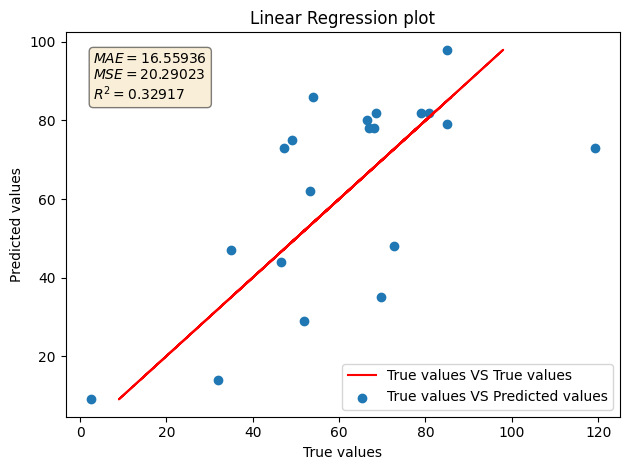

In [20]:
fig, ax = plt.subplots()
ax.plot(y_test_le, y_test_le, 'r', label='True values VS True values')
ax.scatter(pred_test_le, y_test_le, label='True values VS Predicted values')
ax.set_title('Linear Regression plot')
ax.set_ylabel('Predicted values')
ax.set_xlabel('True values')
ax.legend(loc='lower right')

text = '\n'.join((
    r'$MAE=%.5f$' % (mean_absolute_error(y_test_le, pred_test_le), ),
    r'$MSE=%.5f$' % (mean_squared_error(y_test_le, pred_test_le, squared=False), ),
    r'$R^2=%.5f$' % (r2_score(y_test_le, pred_test_le), )
))

ax.text(0.05, 0.95, text, fontsize=10, transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
fig.tight_layout()
fig.savefig('../reports/LR_regression_plot.svg', format='svg', dpi=1200)

### Feature Importance

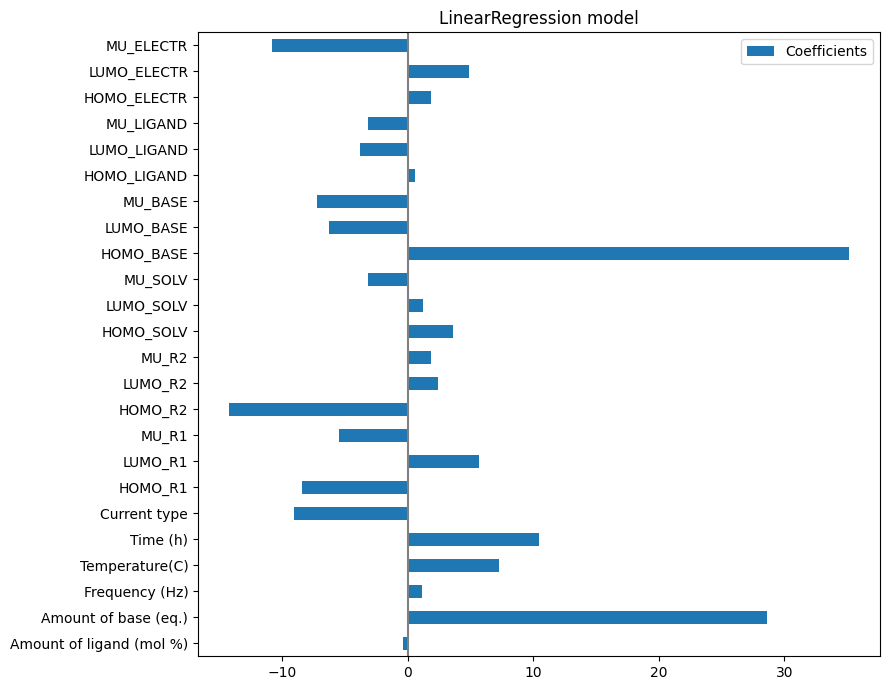

In [21]:
coefs = pd.DataFrame(
   LR[1].coef_,
   columns=['Coefficients'], index=X_train_le.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('LinearRegression model')
plt.axvline(x=0, color='.5')
plt.tight_layout()
plt.savefig('../reports/lr_features_importances.svg', format='svg', dpi=1200)

### **Gradient Boosting**

In [22]:
reg = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.4, max_depth=3, min_samples_leaf=1, min_samples_split=6)
reg.fit(X_train_le, y_train_le)
pred_train_le= reg.predict(X_train_le)
pred_le = reg.predict(X_test_le)

joblib.dump(reg, open('../models/GBR_model.json', 'wb'))

print(f'R2 train = {r2_score(y_train_le, pred_train_le)}')
print(f'MAE train = {mean_absolute_error(y_train_le, pred_train_le)}')
print(f'RMSE train = {mean_squared_error(y_train_le, pred_train_le, squared=False)}')

print('\n')
print(f'R2 test = {r2_score(y_test_le, pred_le)}')
print(f'MAE test = {mean_absolute_error(y_test_le, pred_le)}')
print(f'RMSE test = {mean_squared_error(y_test_le, pred_le, squared=False)}')

R2 train = 0.9994216803389216
MAE train = 0.1469576569052586
RMSE train = 0.6497327711670214


R2 test = 0.8189053209959314
MAE test = 8.360277087737547
RMSE test = 10.542277526776978


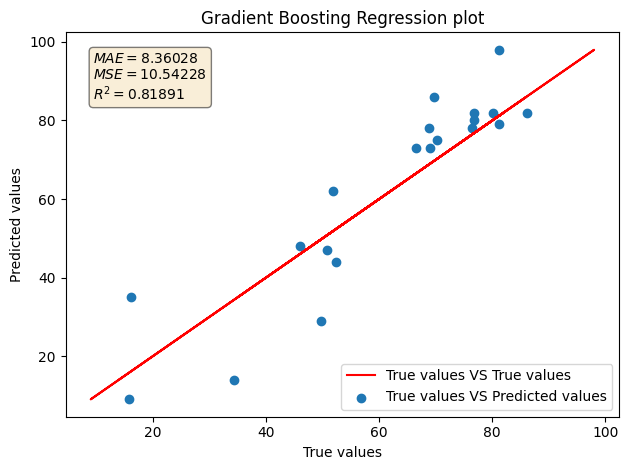

In [23]:
fig, ax = plt.subplots()
ax.plot(y_test_le, y_test_le, 'r', label='True values VS True values')
ax.scatter(pred_le, y_test_le, label='True values VS Predicted values')
ax.set_title('Gradient Boosting Regression plot')
ax.set_ylabel('Predicted values')
ax.set_xlabel('True values')
ax.legend(loc='lower right')

text = '\n'.join((
    r'$MAE=%.5f$' % (mean_absolute_error(y_test_le, pred_le), ),
    r'$MSE=%.5f$' % (mean_squared_error(y_test_le, pred_le, squared=False), ),
    r'$R^2=%.5f$' % (r2_score(y_test_le, pred_le), )
))

ax.text(0.05, 0.95, text, fontsize=10, transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
fig.tight_layout()
fig.savefig('../reports/GRB_regression_plot.svg', format='svg', dpi=1200)

### Feature Importance

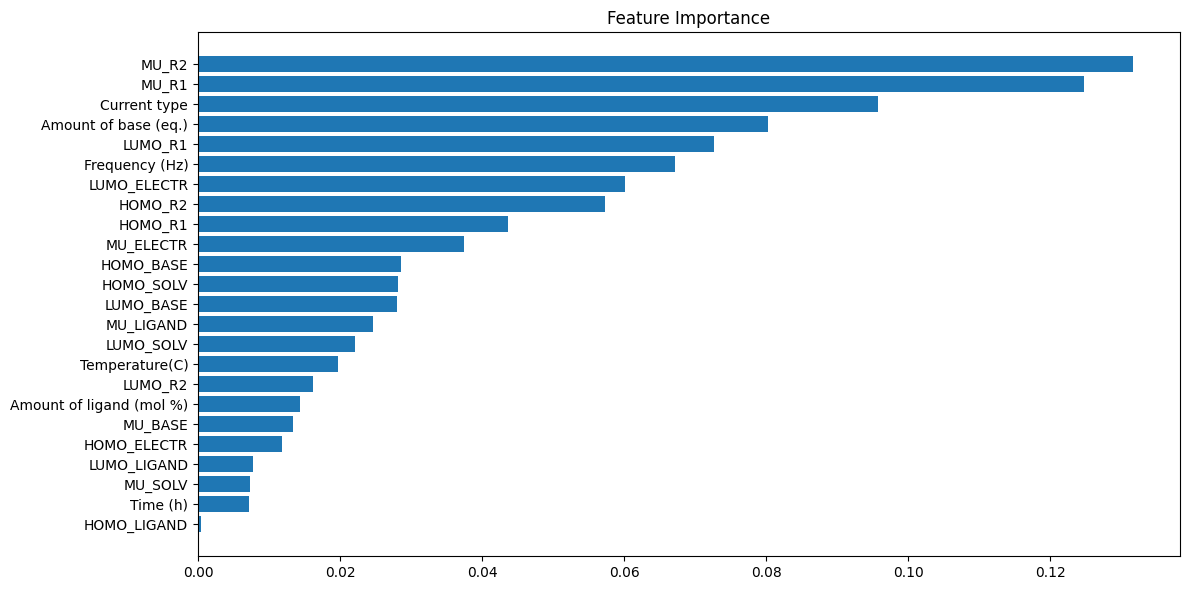

In [24]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_le.columns)[sorted_idx])
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('../reports/GRB_feature_importances.svg', format='svg', dpi=1200)

### **Random Forest**

In [25]:
reg = RandomForestRegressor(n_estimators=100, random_state=2)
reg.fit(X_train_le, y_train_le)
pred_train_le= reg.predict(X_train_le)
pred_le = reg.predict(X_test_le)

joblib.dump(reg, open('../models/RF_model.json', 'wb'))

print(f'R2 train = {r2_score(y_train_le, pred_train_le)}')
print(f'MAE train = {mean_absolute_error(y_train_le, pred_train_le)}')
print(f'RMSE train = {mean_squared_error(y_train_le, pred_train_le, squared=False)}')

print('\n')
print(f'R2 test = {r2_score(y_test_le, pred_le)}')
print(f'MAE test = {mean_absolute_error(y_test_le, pred_le)}')
print(f'RMSE test = {mean_squared_error(y_test_le, pred_le, squared=False)}')

R2 train = 0.8744105607946295
MAE train = 7.730291898577614
RMSE train = 9.574748037794444


R2 test = 0.4422202581566754
MAE test = 14.918066666666666
RMSE test = 18.501756818385292


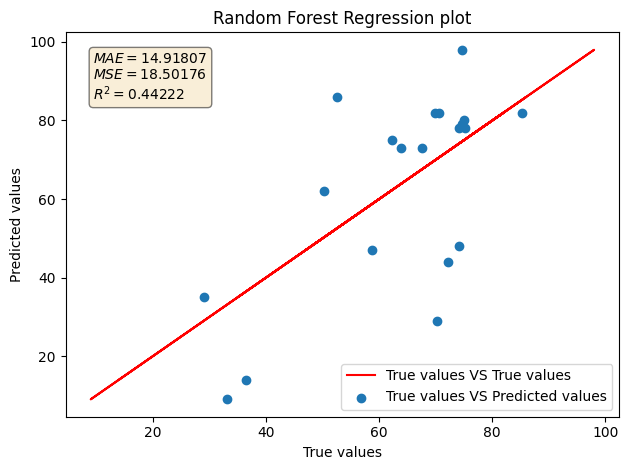

In [26]:
fig, ax = plt.subplots()
ax.plot(y_test_le, y_test_le, 'r', label='True values VS True values')
ax.scatter(pred_le, y_test_le, label='True values VS Predicted values')
ax.set_title('Random Forest Regression plot')
ax.set_ylabel('Predicted values')
ax.set_xlabel('True values')
ax.legend(loc='lower right')

text = '\n'.join((
    r'$MAE=%.5f$' % (mean_absolute_error(y_test_le, pred_le), ),
    r'$MSE=%.5f$' % (mean_squared_error(y_test_le, pred_le, squared=False), ),
    r'$R^2=%.5f$' % (r2_score(y_test_le, pred_le), )
))

ax.text(0.05, 0.95, text, fontsize=10, transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
fig.tight_layout()
fig.savefig('../reports/RF_regression_plot.svg', format='svg', dpi=1200)

### Feature Importance

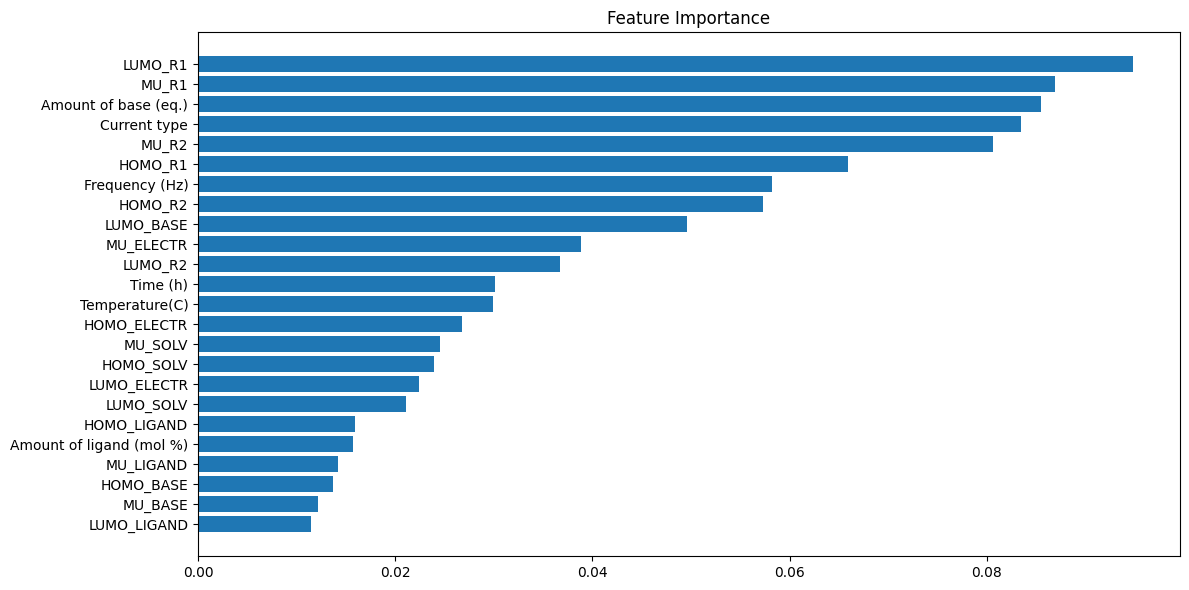

In [27]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_le.columns)[sorted_idx])
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('../reports/RF_feature_importances.svg', format='svg', dpi=1200)